2018 Oct 9<br>
Since I'm getting a little short on time for DPS, I'm going to do a quick once-through of the planned full analysis using the Levenberg-Marquardt approach, with simplified error estimates. Later, I'll go back through with the MCMC analysis to clean up uncertainty estimates.

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import emcee
from emcee.autocorr import integrated_time

import dill

K76 = Kepler76_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


In [57]:
def fit_all_signals(cur_time, cur_baseline, cur_p, cur_b, cur_T0, cur_Aellip, cur_Abeam,
        cur_Aplanet, cur_phase_shift):
    params = K76.saved_params.copy()

    params['baseline'] = cur_baseline
    params['p'] = cur_p
    params['b'] = cur_b
    params['T0'] = cur_T0
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = 0.
    params['Aplanet'] = 0.
    params['phase_shift'] = cur_phase_shift

    cur_BC = BEER_curve(cur_time, params,
            supersample_factor=10, exp_time=30./60./24.)
    
    sig = cur_BC.all_signals()
    
    phi = 2.*np.pi*(cur_time - cur_T0)/params['per']
    refl = -2/np.pi*cur_Aplanet*(np.sin(phi) + (np.pi - phi)*np.cos(phi))
    
    sig += refl

    return sig

In [58]:
bounds = ([-500e-6, 0., -1, K76.T0*0.95, -500e-6, -500e-6, 0., -1],
          [500e-6, 0.2, 1., K76.T0*1.05, 500e-6, 500e-6, 500e-6, 1])

# Estimate scatter
ind = ~transit_indices(folded_time, K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])

time = folded_time
data = filtered_flux
err = unbinned_noise*np.ones_like(folded_time)

initial_guess = [0., K76.saved_params['p'], K76.saved_params['b'], K76.saved_params['T0'], 
                 K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['Aplanet'], K76.saved_params['phase_shift']]
popt, pcov = curve_fit(fit_all_signals, time, data, sigma=unbinned_noise*np.ones_like(time), p0=initial_guess, bounds=bounds)
uncertainties = np.sqrt(pcov.diagonal())

print(popt)
print(uncertainties)

KeyboardInterrupt: 

(-0.0001, 0.0001)

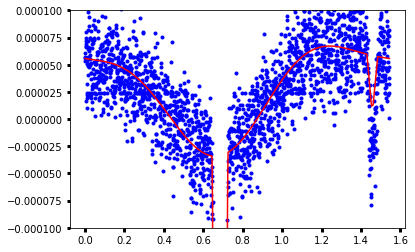

In [29]:
binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, 1./60./24.)

test_popt = popt.copy()
#test_popt[5] = 0.

plt.plot(binned_time, binned_flux, 'b.')
plt.plot(binned_time, fit_all_signals(binned_time, *test_popt), color='red')

plt.ylim([-100e-6, 100e-6])
#plt.xlim([1.4, 1.6])

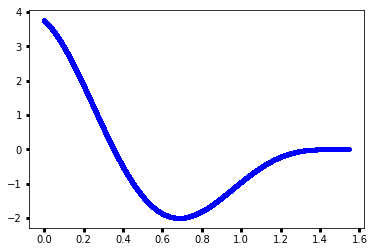

In [56]:
phi = 2.*np.pi*(folded_time - K76.saved_params['T0'])/K76.saved_params['per']
refl = -2/np.pi*(np.sin(phi) + (np.pi - phi)*np.cos(phi))
plt.plot(folded_time, refl, 'b.')

#plt.plot(folded_time, phi/(2.*np.pi),'b.')
#plt.axvline(K76.saved_params['T0'])
#plt.axhline(0.)